# Deep Learning for Image Sementation
##### This file contains python code used as a template for building your model.
##### This includes data preparation and processing of raw images and how to use pre-trained model.

## Import python libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
from zipfile import ZipFile

# For data processing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

cd = os.getcwd()

In [6]:
import tensorflow as tf

ModuleNotFoundError: No module named 'wrapt'

## Unzip dataset

In [ ]:
zipFile = "instance-level-human-parsing.zip"
with ZipFile(os.path.join(cd, zipFile), 'r') as zObject:
    zObject.extractall(path=os.path.join(cd, "instance-level-human-parsing"))

## Data Preparation

###  1. Use publicly available training images and masks
Training and validation datasets are already available in specified folders.

In [ ]:
# Suppose you have already training, validation, and test dataset
image_size = 512
batch_size = 4
num_classes = 20
data_dir = os.path.join(cd, "instance-level_human_parsing/instance-level_human_parsing/instance-level_human_parsing/Training")
num_train_images = 1000
num_val_images = 50

train_images = sorted(glob(os.path.join(data_dir, "Images/*")))[:num_train_images]
train_masks = sorted(glob(os.path.join(data_dir, "Category_ids/*")))[:num_train_images]
val_images = sorted(glob(os.path.join(data_dir, "Images/*")))[num_train_images: num_val_images + num_train_images]
val_masks = sorted(glob(os.path.join(data_dir, "Category_ids/*")))[num_train_images: num_val_images + num_train_images]

def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1) # convert to tensor
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[image_size, image_size])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[image_size, image_size])
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((train_images, train_masks)) # create a dataset including both images and masks
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE) #  'tf_data.AUTOTUNE' dynamically tunes the value of certain parameters in your data input pipeline for optimal performance
    dataset = dataset.batch(batch_size, drop_remainder=True) # If the last batch of data contains fewer elements than the specified batch_size, the last batch is dropped.
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print(f"Train Dataset: {train_dataset}")
print(f"Val Dataset: {val_dataset}")

### 2. Use publicly available training images and masks
Training and validation datasets are not prepared in advance.

In [ ]:
import os

from fontTools.pens.recordingPen import lerpRecordings

cd = os.getcwd()

input_dir = os.path.join(cd, "DeepLearning", "ch9", "images")
target_dir = os.path.join(cd, "DeepLearning","ch9", "annotations", "trimaps")

input_img_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
)
target_paths = sorted(
    [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
)

import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))
plt.show()

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])
    plt.show()

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

# Load inputs and split into a training and a validation set
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)
num_imgs

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### e.g.
#model.fit(train_input_imgs, train_targets, validation_data=(val_input_imgs, val_targets))

### 3. Use widely used benchmark dataset in machine learning and computer vision
E.g., MNIST

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

## Example
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3


I0000 00:00:1753665212.296253   52750 service.cc:152] XLA service 0x7f5848004be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753665212.296287   52750 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation Laptop GPU, Compute Capability 8.9
2025-07-28 09:13:32.315653: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753665212.410127   52750 cuda_dnn.cc:529] Loaded cuDNN version 90501


  27/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4400 - loss: 1.6891

I0000 00:00:1753665214.300837   52750 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8645 - loss: 0.4472

2025-07-28 09:13:46.942557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads

2025-07-28 09:13:47.175499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 92 bytes spill stores, 92 bytes spill loads

2025-07-28 09:13:47.202745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 76 bytes spill stores, 76 bytes spill loads

2025-07-28 09:13:49.006038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 76 bytes spill stores, 76 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8645 - loss: 0.4471 - val_accuracy: 0.9585 - val_loss: 0.1465
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9534 - loss: 0.1632 - val_accuracy: 0.9674 - val_loss: 0.1134
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9631 - loss: 0.1265 - val_accuracy: 0.9752 - val_loss: 0.0961
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9693 - loss: 0.1076
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## Use pre-trained model directly using network architecture (zero-shot performance)

## 1. SAM (Segment Anything Model)
there is SAM2. Is this available for Tensorflow or only on PyTorch?<br>
https://keras.io/keras_hub/guides/segment_anything_in_keras_hub/<br>
https://blog.roboflow.com/how-to-use-segment-anything-model-sam/
https://github.com/IDEA-Research/Grounded-Segment-Anything


### Overview
The Segment Anything Model (SAM) <span style="color:red">produces high quality object masks from input prompts such as points or boxes</span>, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has <span style="color:red">strong zero-shot performance</span> on a variety of segmentation tasks.

In this guide, we will show how to use KerasHub's implementation of the Segment Anything Model and show how powerful TensorFlow's and JAX's performance boost is.

First, let's get all our dependencies and images for our demo.

In [3]:
!!wget -q https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


### Choose your backend
With Keras 3, you can choose to use your favorite backend.
As of Keras 3.0, the primary supported backends are TensorFlow, JAX, and PyTorch

In [3]:
import os
# os.environ["KERAS_BACKEND"] = "jax" # this fails

import timeit
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras_hub
from tensorflow.keras import ops
import tensorflow_datasets as tfds

### Helper functions
Let's define some helper functions for visulazing the images, prompts, and the segmentation results.

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasHub now rescales the images and normalizes them.
        # Just unnormalize such that when KerasHub normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

### Get the pre-trained SAM model
We can initialize a trained SAM model using KerasHub's from_preset factory method. Here, we use the huge ViT backbone trained on the SA-1B dataset (**sam_huge_sa1b**) for high-quality segmentation masks.<br>
You can also use one of the **sam_large_sa1b** or **sam_base_sa1b** for better performance (at the cost of decreasing quality of segmentation masks).

In [5]:
model = keras_hub.models.SAMImageSegmenter.from_preset("sam_huge_sa1b")

I0000 00:00:1753682162.668492   74583 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12810 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Understanding Prompts
Segment Anything allows <span style="color:red">prompting an image</span> using points, boxes, and masks:

   1. Point prompts are the most basic of all: the model tries to guess the object given a point on an image. The point can either be a foreground point (i.e. the desired segmentation mask contains the point in it) or a backround point (i.e. the point lies outside the desired mask).
   2. Another way to prompt the model is using boxes. Given a bounding box, the model tries to segment the object contained in it.
   3. Finally, the model can also be prompted using a mask itself. This is useful, for instance, to refine the borders of a previously predicted or known segmentation mask.

What makes the model incredibly powerful is the ability to combine the prompts above. Point, box, and mask prompts can be combined in several different ways to achieve the best result.
Let's see the semantics of passing these prompts to the Segment Anything model in KerasHub. Input to the SAM model is a dictionary with keys:

   1. <span style="color:red">"images"</span>: A batch of images to segment. Must be of shape <span style="color:red">(B, 1024, 1024, 3)</span>.
   2. <span style="color:red">"points"</span>: A batch of point prompts. Each point is an <span style="color:red">(x, y)</span> coordinate originating from the top-left corner of the image. In other works, each point is of the form <span style="color:red">(r, c)</span> where r and c are the row and column of the pixel in the image. Must be of shape <span style="color:red">(B, N, 2)</span>.
   3. <span style="color:red">"labels"</span>: A batch of labels for the given points. 1 represents foreground points and 0 represents background points. Must be of shape <span style="color:red">(B, N)</span>.
   4. <span style="color:red">"boxes"</span>: A batch of boxes. Note that the model only accepts one box per batch. Hence, the expected shape is <span style="color:red">(B, 1, 2, 2)</span>. Each box is a collection of 2 points: the top left corner and the bottom right corner of the box. The points here follow the same semantics as the point prompts. Here the 1 in the second dimension represents the presence of box prompts. If the box prompts are missing, a placeholder input of shape <span style="color:red">(B, 0, 2, 2)</span> must be passed.
   5. <span style="color:red">"masks"</span>: A batch of masks. Just like box prompts, only one mask prompt per image is allowed. The shape of the input mask must be <span style="color:red">(B, 1, 256, 256, 1)</span> if they are present and <span style="color:red">(B, 0, 256, 256, 1)</span> for missing mask prompt.

Placeholder prompts are only required when calling the model directly (i.e. model(...)). When calling the <span style="color: red">predict</span> method, missing prompts can be omitted from the input dictionary.


### Point prompts

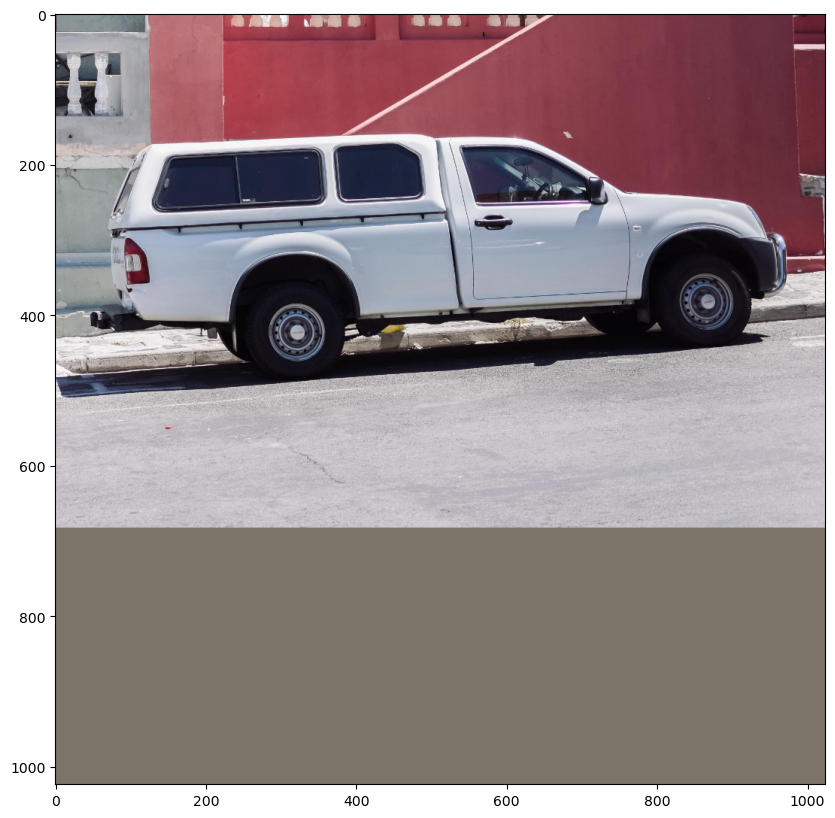

In [6]:
# Load our image
image = np.array(keras.utils.load_img("truck.jpg"))
image = inference_resizing(image)

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
plt.axis("on")
plt.show()

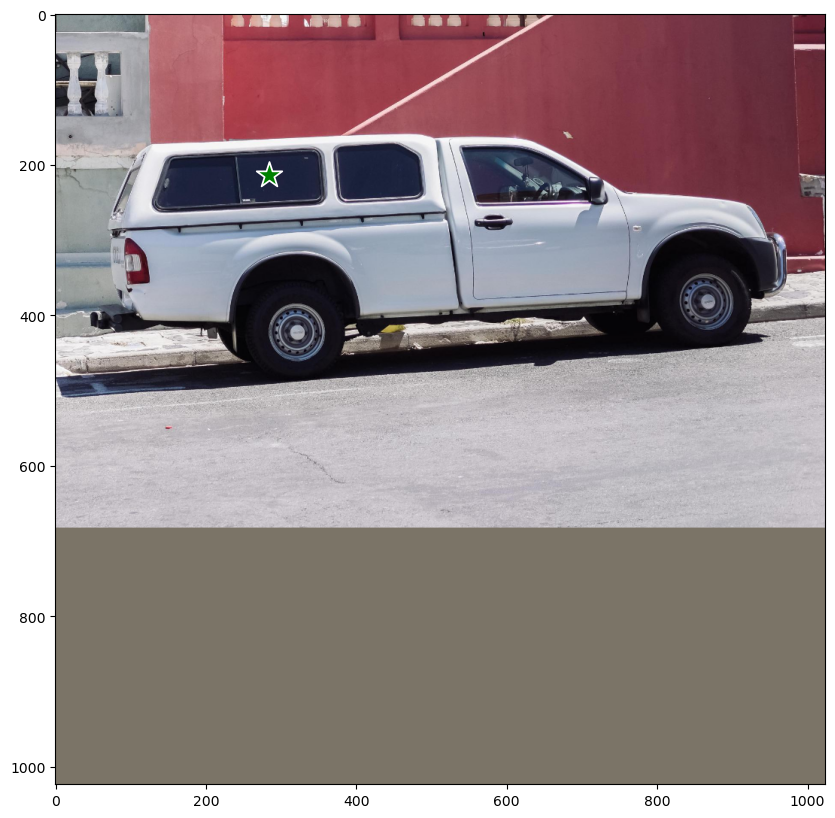

In [7]:
# Define the input point prompt
input_point = np.array([[284, 213.5]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

Now let's call the predict method of our model to get the segmentation masks.

**Note**: We don't call the model directly (model(...)) since placeholder prompts are required to do so. Missing prompts are handled automatically by the predict method so we call it instead. Also, when no box prompts are present, the points and labels need to be padded with a zero point prompt and -1 label prompt respectively. The cell below demonstrates how this works.

In [8]:
outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": np.concatenate(
            [input_point[np.newaxis, ...], np.zeros((1, 1, 2))], axis=1
        ),
        "labels": np.concatenate(
            [input_label[np.newaxis, ...], np.full((1, 1), fill_value=-1)], axis=1
        ),
    }
)

I0000 00:00:1753682211.273823   75155 service.cc:152] XLA service 0x7fb0e8003a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753682211.273850   75155 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation Laptop GPU, Compute Capability 8.9
2025-07-28 13:56:51.603895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753682212.581234   75155 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-07-28 13:56:54.647604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1441', 116 bytes spill stores, 116 bytes spill loads

2025-07-28 13:56:54.651969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'g

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


<span style="color:red">SegmentAnythingModel.predict</span> returns two outputs. First are logits (segmentation masks) of shape <span style="color:red">(1, 4, 256, 256)</span> and the other are the IoU confidence scores (of shape (1, 4)) for each mask predicted. The pretrained SAM model predicts four masks: the first is the best mask the model could come up with for the given prompts, and the other 3 are the alternative masks which can be used in case the best prediction doesn't contain the desired object. The user can choose whichever mask they prefer.

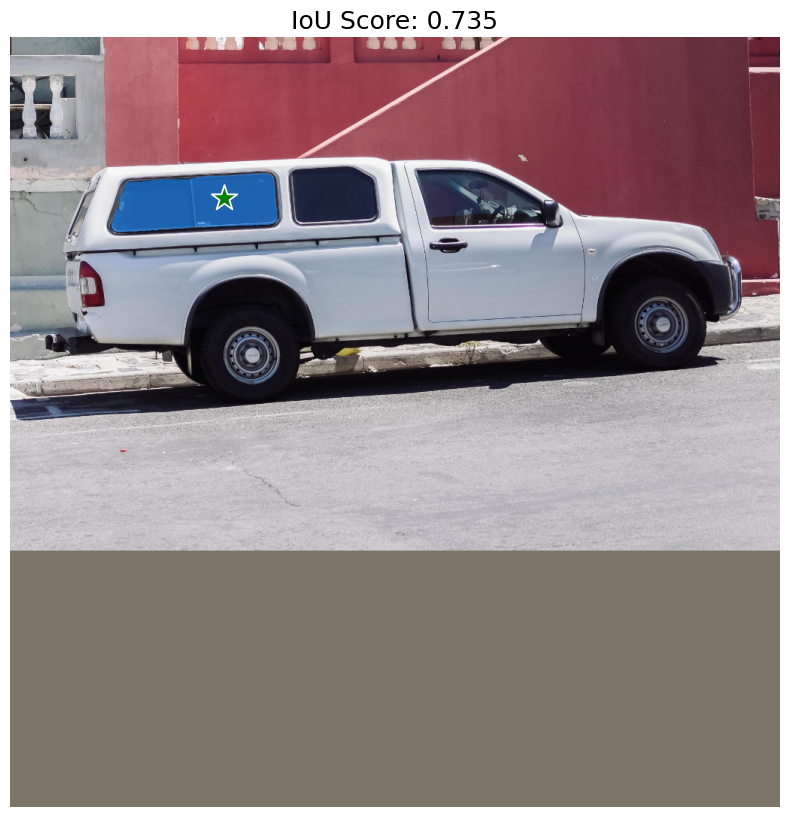

In [9]:
# Resize the mask to our image shape i.e. (1024, 1024)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
# Convert the logits to a numpy array
# and convert the logits to a boolean mask
mask = ops.convert_to_numpy(mask) > 0.0
iou_score = ops.convert_to_numpy(outputs["iou_pred"][0][0])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"IoU Score: {iou_score:.3f}", fontsize=18)
plt.axis("off")
plt.show()

As expected, the model returns a segmentation mask for the truck's window pane. But, our point prompt can also mean a range of other things. For example, another possible mask that contains our point is just the right side of the window pane or the whole truck.

Let's also visualize the other masks the model has predicted.

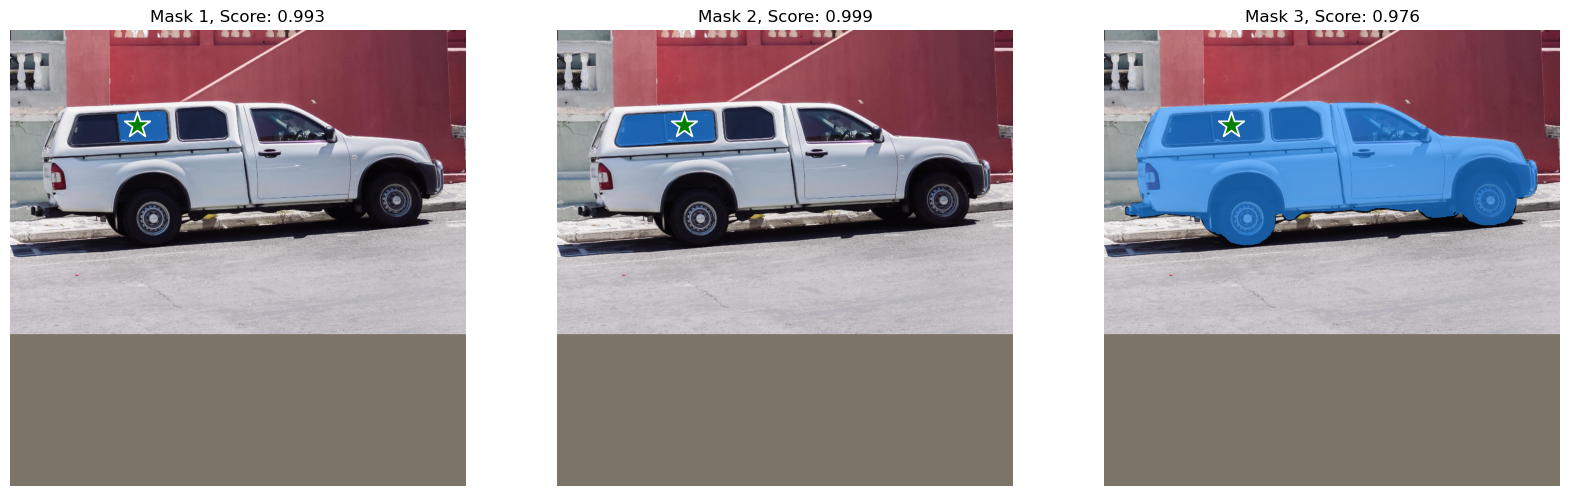

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
masks, scores = outputs["masks"][0][1:], outputs["iou_pred"][0][1:]
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = inference_resizing(mask[..., None], pad=False)[..., 0]
    mask, score = map(ops.convert_to_numpy, (mask, score))
    mask = 1 * (mask > 0.0)
    ax[i].imshow(ops.convert_to_numpy(image) / 255.0)
    show_mask(mask, ax[i])
    show_points(input_point, input_label, ax[i])
    ax[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=12)
    ax[i].axis("off")
plt.show()

### Box prompts
Now, let's see how we can prompt the model using boxes. The box is specified using two points, the top-left corner and the bottom-right corner of the bounding box in xyxy format. Let's prompt the model using a bounding box around the left front tyre of the truck.

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


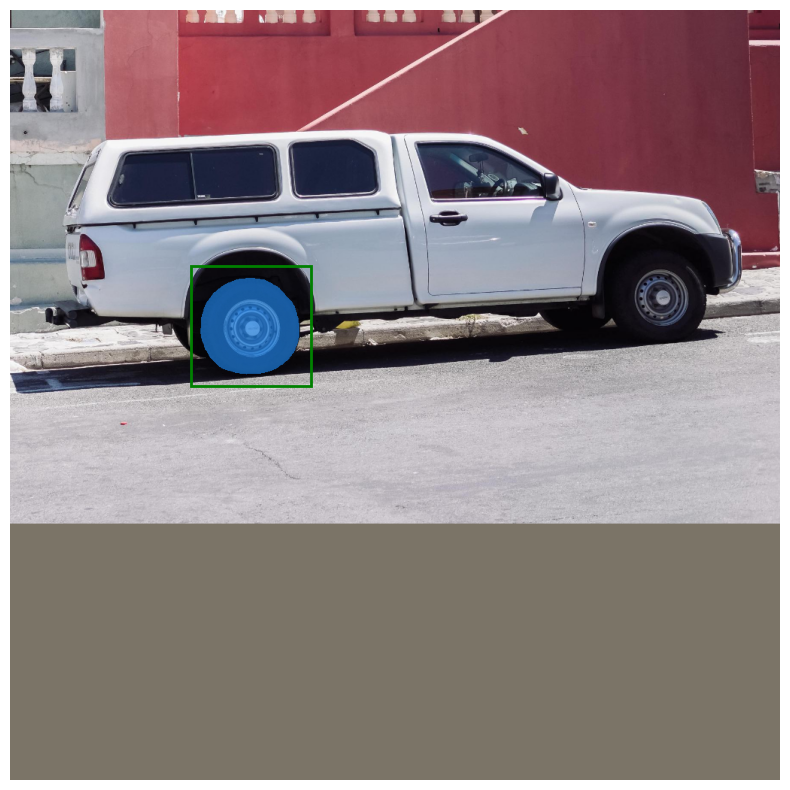

In [11]:
# Let's specify the box
input_box = np.array([[240, 340], [400, 500]])

outputs = model.predict(
    {"images": image[np.newaxis, ...],
     "boxes": input_box[np.newaxis, np.newaxis, ...]}
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.axis("off")
plt.show()

## Combining prompts
To get the true potential of the model out, let's combine box and point prompts and see what the model does.

2025-07-28 13:57:38.696281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 408 bytes spill stores, 408 bytes spill loads

2025-07-28 13:57:39.785226: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_230', 236 bytes spill stores, 236 bytes spill loads

2025-07-28 13:57:40.163315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_230', 364 bytes spill stores, 364 bytes spill loads

2025-07-28 13:57:40.916840: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 4 bytes spill stores, 4 bytes spill loads

2025-07-28 13:57:41.502357: I external/l

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


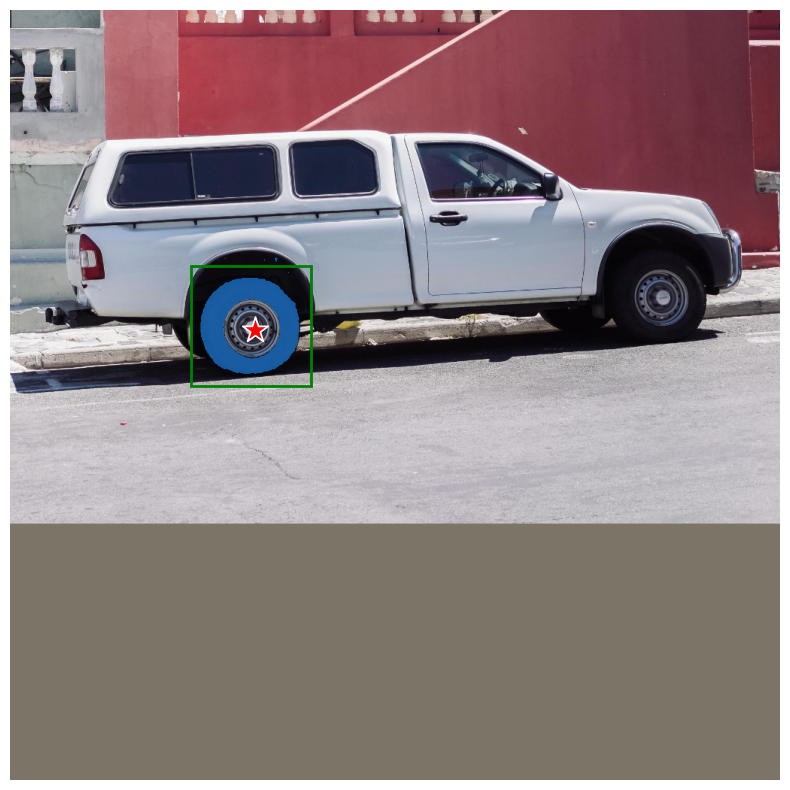

In [12]:
# Let's specify the box
input_box = np.array([[240, 340], [400, 500]])
input_point = np.array([[325, 425]])
input_label = np.array([0])

outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": input_point[np.newaxis, ...],
        "labels": input_label[np.newaxis, ...],
        "boxes": input_box[np.newaxis, np.newaxis, ...]
    }
)

mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

### Text prompts
Finally, let's see how text prompts can be used along with KerasHub's <span style="color:red">SegmentAnythingModel</span>.

For this demo, we will use the <span style="color:red">official Grounding DINO model(https://github.com/IDEA-Research/GroundingDINO)</span>. Grounding DINO is a model that takes as input a <span style="color:red">(image, text)</span> pair and generates a bounding box around the object in the <span style="color:red">image</span> described by the text. You can refer to the paper for more details on the implementation of the model.

For this part of the demo, we will need to install the groundingdino package from source:

In [43]:
!!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

['/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)']

In [1]:
from groundingdino.util.inference import Model as GroundingDINO

CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

2025-07-28 13:54:36.554969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 13:54:36.715149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753682076.772931   74583 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753682076.792296   74583 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753682076.926899   74583 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_

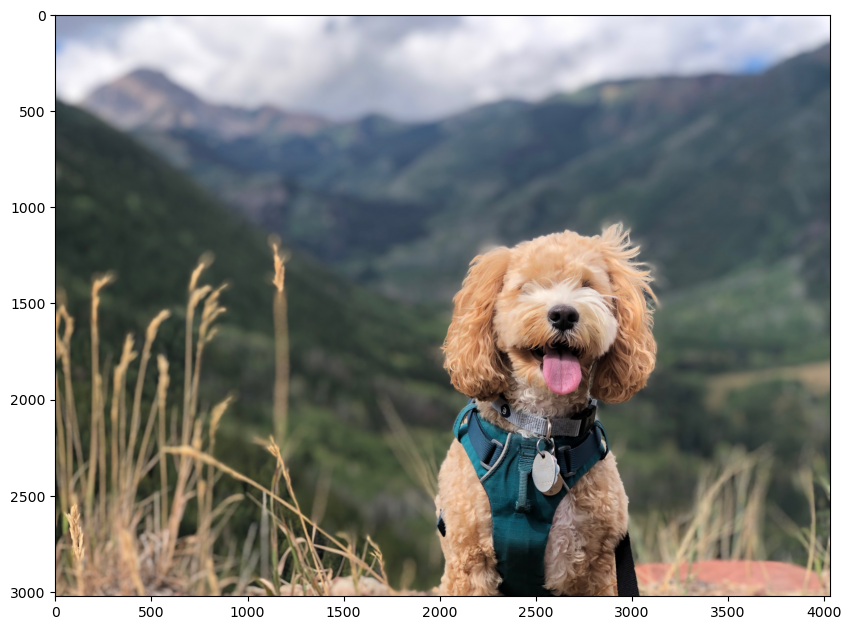

In [13]:
filepath = keras.utils.get_file(origin="https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg")
image = np.array(keras.utils.load_img(filepath))

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()


We first predict the bounding box of the object we want to segment using the Grounding DINO model. Then, we prompt the SAM model using the bounding box to get the segmentation mask.

Let's try to segment out the harness of the dog. Change the image and text below to segment whatever you want using text from your image!

In [14]:
# Let's predict the bounding box for the harness of the dog
boxes = grounding_dino.predict_with_caption(image.astype(np.uint8), "harness")
boxes = np.array(boxes[0].xyxy)

outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/transformers/modeling_utils.py:1731: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/groundingdino/models/GroundingDINO/transformer.p

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


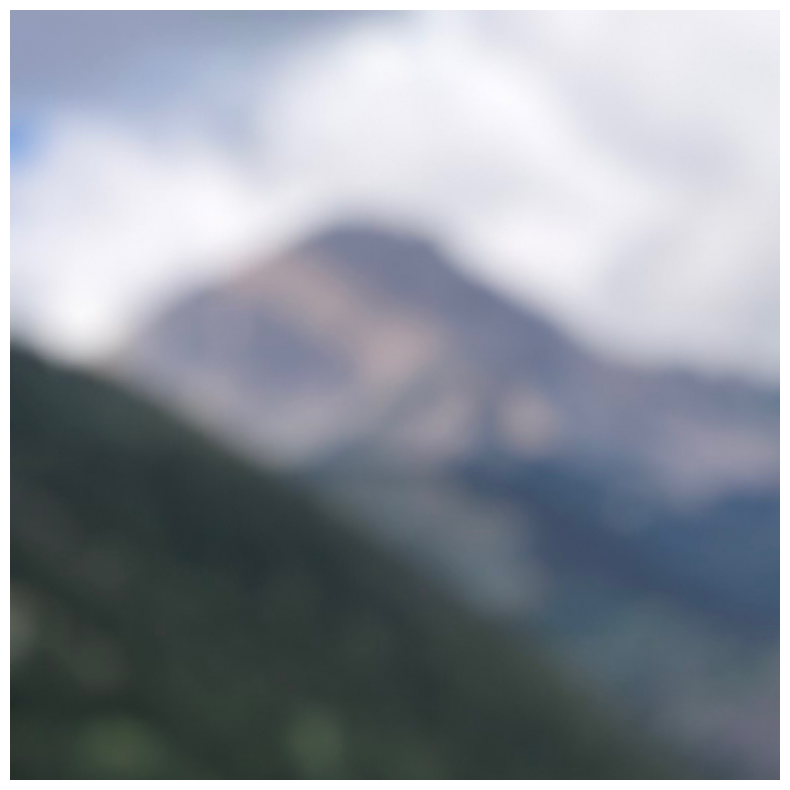

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = inference_resizing(mask[0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

And that's it! We got a segmentation mask for our text prompt using the combination of Gounding DINO + SAM! This is a very powerful technique to combine different models to expand the applications!

Let's visualize the results.

## Conclusion

Conclusion
KerasHub's SegmentAnythingModel supports a variety of applications and, with the help of Keras 3, enables running the model on TensorFlow, JAX, and PyTorch! With the help of XLA in JAX and TensorFlow, the model runs several times faster than the original implementation. Moreover, using Keras's mixed precision support helps optimize memory use and computation time with just one line of code!

For more advanced uses, check out the <span style="color:red">Automatic Mask Generator demo</span> (https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Automatic_Mask_Generator_Demo.ipynb).

# Grounded Segment Anything (GroundingDino + SAM)
* <span style="color:red">Segment Anything</span> is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
* <span style="color:red">Grounding DINO</span> is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
* The combination of the two models enable to detect and segment everything with text inputs!<br>
https://github.com/IDEA-Research/Grounded-Segment-Anything

In [1]:
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2025-07-29 08:29:05.809376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 08:29:05.993295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753748946.056268    7655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753748946.074934    7655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753748946.231187    7655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# download the pretrained groundingdino-swin-tiny model
# !wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


In [2]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### GroundingDino (no segmentation)

In [3]:
# Define file names and model names
home_dir = "/home/eiji"
output_dir_name = "Output_sample"
annotated_file_name = "annotated_image.jpg"
checkpoint_path = "groundingdino_swint_ogc.pth"
config_path = "GroundingDINO_SwinT_OGC.py"

# Create a new directory
cd = os.getcwd()
print(cd)

output_dir = os.path.join(cd, output_dir_name)
output_sam = os.path.join(output_dir, "SAM")

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

if not os.path.exists(output_sam):
    os.mkdir(output_sam)

/home/eiji/PycharmProjects/PythonProject/DeepLearning


#### GroundingDino (detect objects)

##### Read a model

In [4]:
# Read a model
# model = load_model("./GroundingDINO_SwinT_OGC.py", "./groundingdino_swint_ogc.pth")
model = load_model(config_path, checkpoint_path)

# Input image
input_img_dir = os.path.join(home_dir, "Grounded-Segment-Anything", "assets")
IMAGE_PATH = os.path.join(input_img_dir, "demo1.jpg")

# Define text prompts
TEXT_PROMPT = "bear."
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730772320024/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_

##### Load image and run Grounding DINO

In [83]:
boxes.dtype

torch.float32

In [81]:
# Load the image
image_source, image = load_image(IMAGE_PATH)

# Run zero-shot model
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite(os.path.join(output_sam, annotated_file_name), annotated_frame)

True

##### Visualize raw image and <span style="color:red">'Grounding DINO'</span> (bounding box)

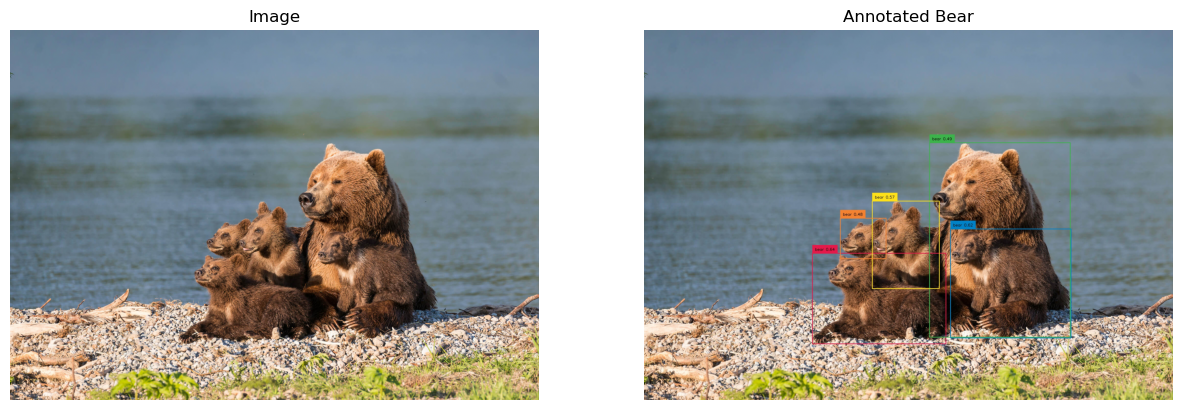

In [71]:
# Visualize raw image and annotated image
image_anno = np.array(keras.utils.load_img(os.path.join(output_sam, annotated_file_name)))
image_raw = np.array(keras.utils.load_img(IMAGE_PATH))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# Original image
ax[0].imshow(image_raw / 255.0)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(image_anno / 255.0)
ax[1].set_title("Annotated Image")
ax[1].axis("off")
plt.show()


### Grounded-SAM (GroundingDino + SAM)
https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.TriangleAnnotator.annotate

#### Example 1

In [5]:
import cv2
import numpy as np
import supervision as sv

import torch
import torchvision

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [168]:
annotated_file_name = "groundingdino_annotated_image.jpg"
annotated_seg_file_name = "grounded_SAM_image.jpg"
checkpoint_path = "groundingdino_swint_ogc.pth"
config_path = "GroundingDINO_SwinT_OGC.py"

# Segment-Anything checkpoint
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

In [169]:
# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=config_path, model_checkpoint_path=checkpoint_path)

# Building SAM Model and SAM Predictor
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_

In [193]:
# Predict captions and hyper-param for GroundingDINO
# Input image
input_img_dir = os.path.join(home_dir, "Grounded-Segment-Anything", "assets")
TEXT_PROMPT = "bear. grass." ## for multiple prompts: "bear. water. grass."
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

# load image
image = cv2.imread(IMAGE_PATH)
image_source, image2 = load_image(IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_caption(
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

boxes = torch.from_numpy(detections[0].xyxy)
confidence = detections[0].confidence
phrases = detections[-1]

# labels
labels = [f"{name} {conf:.2f}" for name, conf in zip(phrases, confidence)]

box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections[0], labels=labels)

# save the annotated grounding dino image
cv2.imwrite(os.path.join(output_sam, annotated_file_name), annotated_frame)

True

In [167]:
# NMS post process
# print(f"Before NMS: {len(detections[0].xyxy)} boxes")
# nms_idx = torchvision.ops.nms(
#     torch.from_numpy(detections[0].xyxy),
#     torch.from_numpy(detections[0].confidence),
#     NMS_THRESHOLD
# ).numpy().tolist()

# detections.xyxy = detections[0].xyxy[nms_idex]
# detections.confidence = detections[0].confidence[nms_idx]
# detections.class_id = detections[0].class_id[nms_idx]
#
# print(f"After NMS: {len(detections[0].xyxy)} boxes")

In [194]:
# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [195]:
# convert detections to masks
detections[0].mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections[0].xyxy # when using predict_captions
)

# annotate image with detections
transparent_bbox_line = sv.Color(r=0, g=0, b=0)
box_annotator = sv.BoxAnnotator(thickness=0)
mask_annotator = sv.MaskAnnotator()

labels = [f"{name} {conf:.2f}" for name, conf in zip(detections[-1], confidence)]

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections[0])
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections[0], labels=labels)

# save the annotated grounded-sam image
cv2.imwrite(os.path.join(output_sam, annotated_seg_file_name), annotated_image) # only SAM with no bbox

True

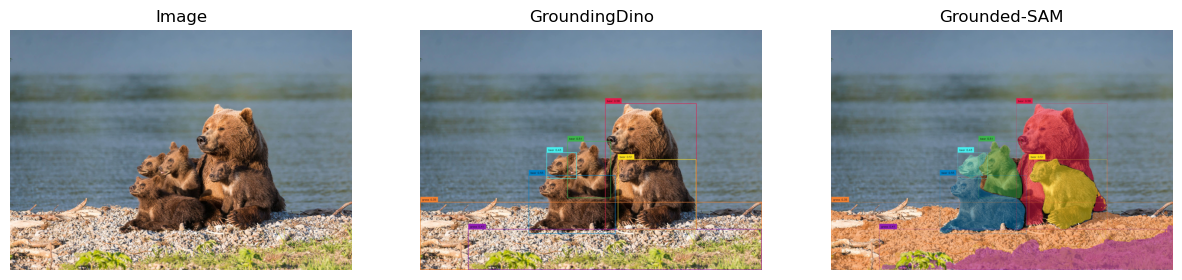

In [196]:
# Visualize all
image_bbox = np.array(keras.utils.load_img(os.path.join(output_sam, annotated_file_name)))
image_sam = np.array(keras.utils.load_img(os.path.join(output_sam, annotated_seg_file_name)))
image_raw = np.array(keras.utils.load_img(IMAGE_PATH))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15, 15))

# Original image
ax[0].imshow(image_raw / 255.0)
ax[0].set_title("Image")
ax[0].axis("off")

# GroundingDino (bbox)
ax[1].imshow(image_bbox / 255.0)
ax[1].set_title("GroundingDino")
ax[1].axis("off")

# Grounded-SAM
ax[2].imshow(image_sam / 255.0)
ax[2].set_title("Grounded-SAM")
ax[2].axis("off")

plt.show()

#### Example 2 (Running dog)
https://github.com/IDEA-Research/Grounded-Segment-Anything/blob/main/grounded_sam_simple_demo.py

In [80]:
import cv2
import numpy as np
import supervision as sv

import torch
import torchvision

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [81]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [110]:
# Define file names and model names
home_dir = "/home/eiji"
output_dir_name = "Output_sample"
annotated_file_name = "groundingdino_annotated_image.jpg"
annotated_seg_file_name = "grounded_segmentation_annotated_image.jpg"
checkpoint_path = "groundingdino_swint_ogc.pth"
config_path = "GroundingDINO_SwinT_OGC.py"

# Segment-Anything checkpoint
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

In [82]:
# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=config_path, model_checkpoint_path=checkpoint_path)

# Building SAM Model and SAM Predictor
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


/home/eiji/anaconda3/envs/tf-ws/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [107]:
# Predict classes and hyper-param for GroundingDINO
# Input image
input_img_dir = os.path.join(home_dir, "Grounded-Segment-Anything", "assets")
SOURCE_IMAGE_PATH = os.path.join(input_img_dir, "demo2.jpg")
CLASSES = ["The running dog"]
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
# original: f"{CLASSES[class_id]} {confidence:0.2f}"
labels = [
    f"{confidence:0.2f}" for _, _, confidence, class_id, _  in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# save the annotated grounding dino image
cv2.imwrite(os.path.join(output_sam, annotated_file_name), annotated_frame)

True

In [115]:
# NMS post process
print(f"Before NMS: {len(detections.xyxy)} boxes")
nms_idx = torchvision.ops.nms(
    torch.from_numpy(detections.xyxy),
    torch.from_numpy(detections.confidence),
    NMS_THRESHOLD
).numpy().tolist()

detections.xyxy = detections.xyxy[nms_idx]
detections.confidence = detections.confidence[nms_idx]
detections.class_id = detections.class_id[nms_idx]

print(f"After NMS: {len(detections.xyxy)} boxes")

Before NMS: 1 boxes
After NMS: 1 boxes


In [116]:
# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [117]:
# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

# original: f"{CLASSES[class_id]} {confidence:0.2f}"
labels = [
    f"{confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# save the annotated grounded-sam image
cv2.imwrite(os.path.join(output_sam, annotated_seg_file_name), annotated_image)

True

### Semantic-SAM
https://github.com/UX-Decoder/Semantic-SAM/tree/main